In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import yaml

sys.path.append("../")
from globals import ACCURACY_METRICS, UNCERTAINTY_METRICS
from probabilistic.HMC.adv_robust_dp_hmc import AdvHamiltonianMonteCarlo
from probabilistic.HMC.hyperparams import HyperparamsHMC
from probabilistic.HMC.vanilla_bnn import VanillaBnnMnist
from common.dataset_utils import load_mnist
from globals import TORCH_DEVICE
from experiment_utils import test_ibp_acc_from_file

In [4]:
print(type(globals()['_dh'][0]))
curr_dir = str(globals()['_dh'][0])
#! 5 different models: dnn_sgd, hmc, fgsm_hmc, pgd_hmc, ibp_hmc
#! 8 metrics: std_acc, fgsm_acc, pgd_acc, ibp_acc, in_distrib_auroc, in_distrib_ece, ood_auroc, ood_ece
#? maybe privacy?
def plot_metrics(dataset_name: str = "MNIST", metric_type = "accuracy", for_adv_comparison: bool = True):
    # now fill them up with the results from the yaml file
    fname = "/results_adv.yaml" if for_adv_comparison else "/results_all.yaml"
    adv_results_file = curr_dir + fname
    experiments_results = None
    with open(adv_results_file, 'r', encoding="utf-8") as file:
        experiments_results = yaml.safe_load(file)[dataset_name]

    models = list(experiments_results.keys())
    positions = np.arange(0, len(models), 1)
    colors = ["#d46d3d", "#e3c268", "#ccf56e", "#64d199", "#68a0e3"]
    hlines = np.arange(0, 1.1, 0.1)

    desired_metrics = ACCURACY_METRICS if metric_type == "accuracy" else UNCERTAINTY_METRICS

    fig, ax = plt.subplots(2, 2, figsize=(30, 20), constrained_layout=True)
    for idx, metric in enumerate(desired_metrics):
        row, col = idx // 2, idx % 2
        heights = [experiments_results[model][metric] for model in models]
        ax[row, col].bar(positions, height=heights, width=0.5, align='center', color=colors, tick_label=models, alpha=0.9)
        ax[row, col].set_ylim(0, 1)
        ax[row, col].set_yticks(hlines)
        ax[row, col].hlines(hlines, -0.5, len(models) - 1 + 0.5, colors="gray", alpha=0.3)
        ax[row, col].set_title(metric)
        ax[row, col].set_ylabel("Accuracy")
        ax[row, col].set_xlabel("Training method")

    fig.show()
    plt.show()

<class 'pathlib.PosixPath'>


<class 'pathlib.PosixPath'>


/tmp/ipykernel_7107/3079682077.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


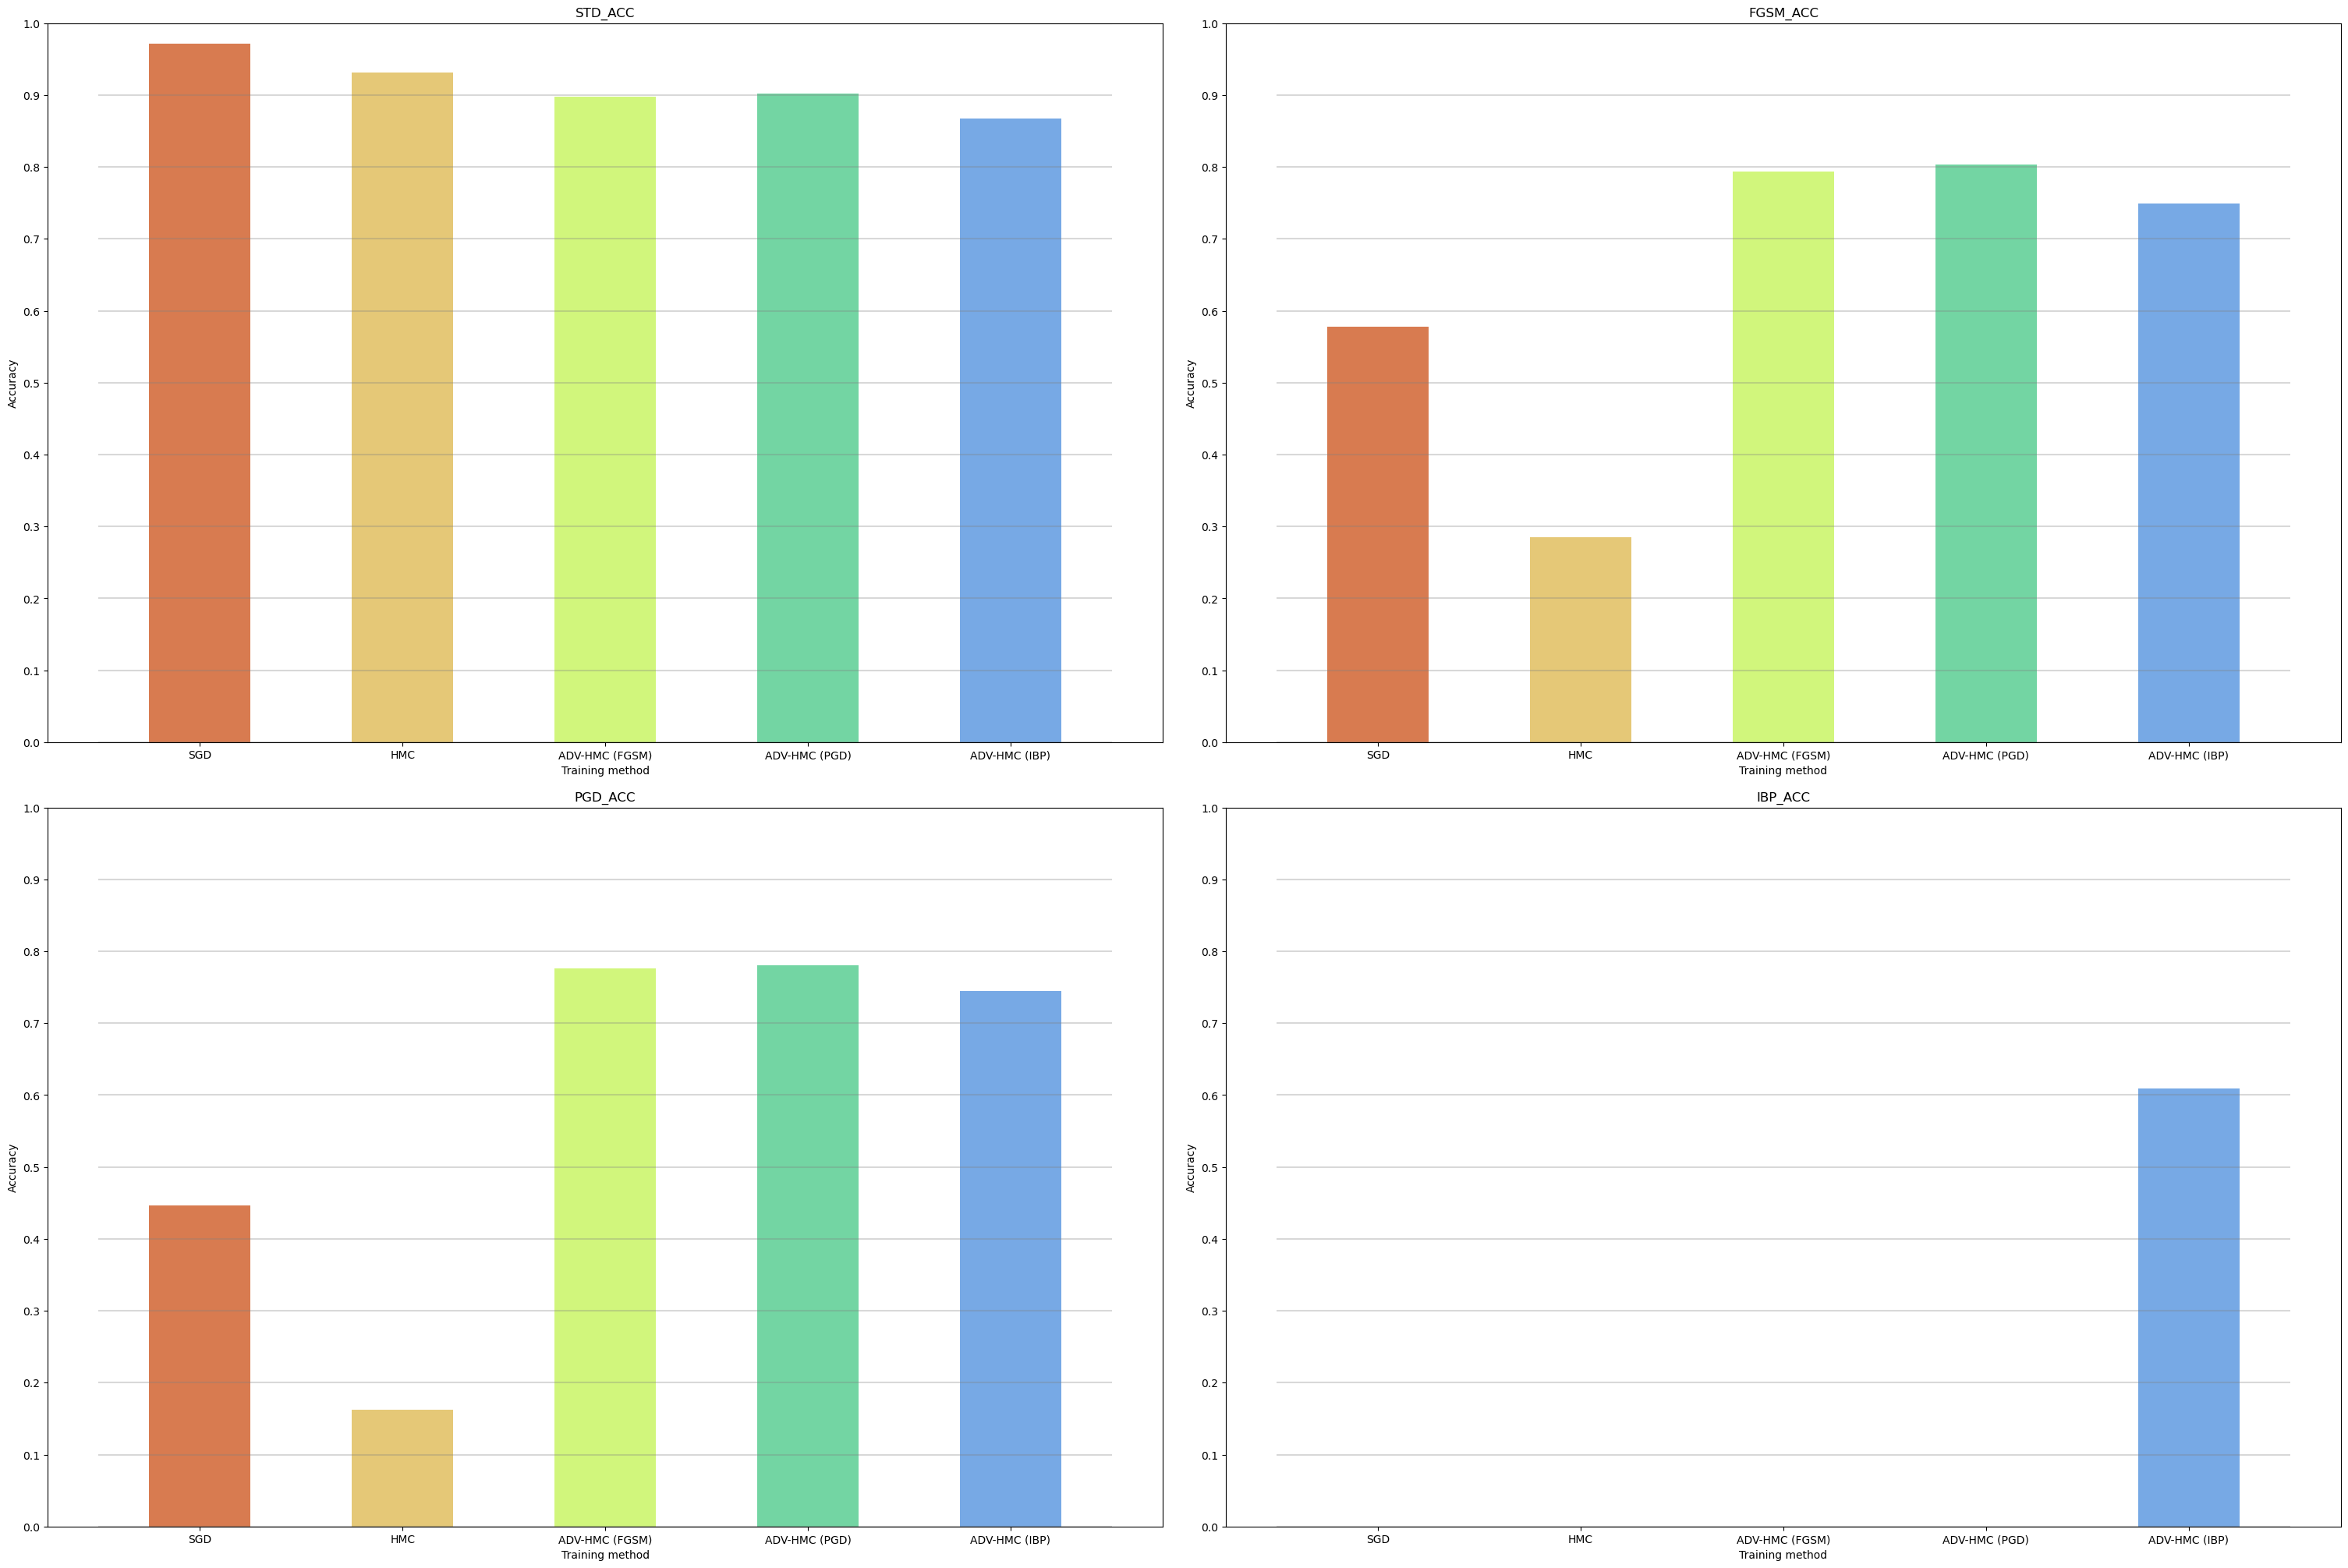

In [3]:
plot_metrics("MNIST")

<class 'pathlib.PosixPath'>


/tmp/ipykernel_7107/3079682077.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


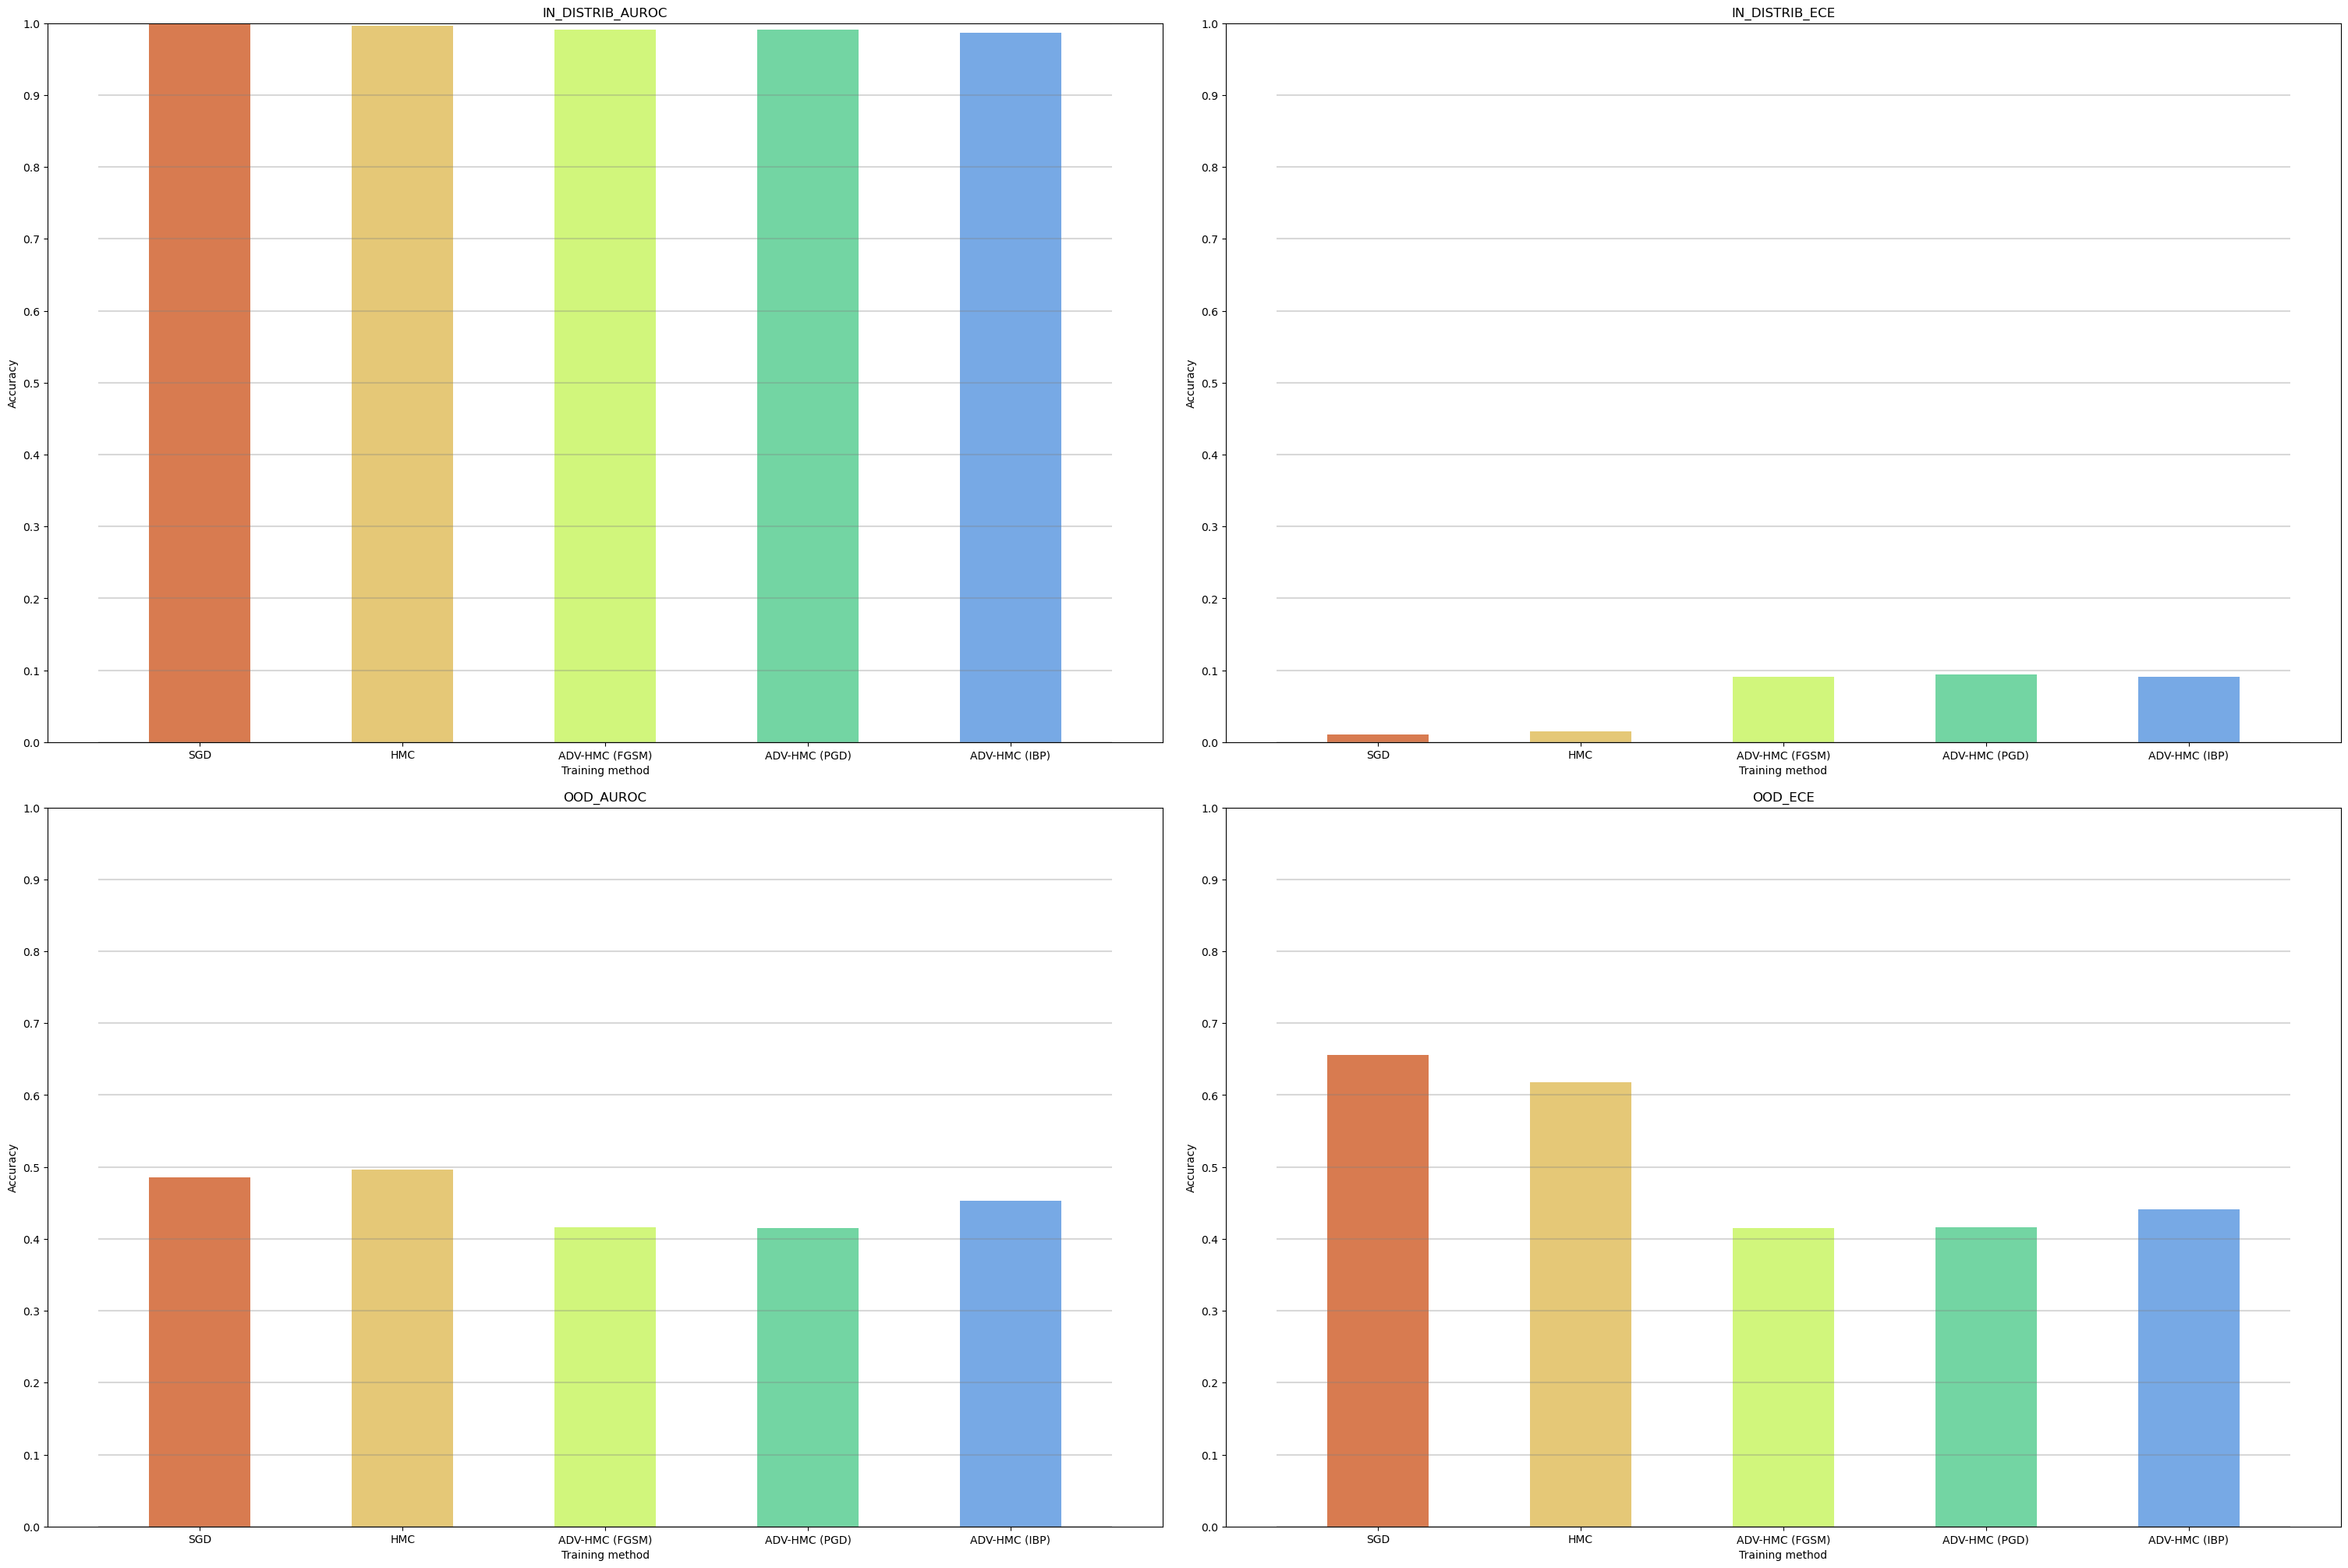

In [4]:
plot_metrics("MNIST", "uncertainty")

In [11]:
vanilla_bnn = VanillaBnnMnist().to(TORCH_DEVICE)
train_data, test_data = load_mnist()
hyperparams = HyperparamsHMC(num_epochs=25, num_burnin_epochs=0, step_size=1e-2, warmup_step_size=0.2, lf_steps=120, batch_size=500, momentum_std=0.001,
                             alpha=0.5, eps=0.1, decay_epoch_start=20, lr_decay_magnitude=0.1, eps_warmup_epochs=0, alpha_warmup_epochs=0, run_dp=False)
hmc = AdvHamiltonianMonteCarlo(vanilla_bnn, hyperparams)
epsilons = np.linspace(0, 0.1, 11).tolist()
accs = test_ibp_acc_from_file(hmc, test_data, curr_dir + "/posterior_samples/ibp_hmc_mnist.npy", epsilons)
print(accs)

Current directory: /home/raoden/fyp/RobustnessPrivacyTradeoffInBNNs/experiments/..
Len posterior samples: 27
Average value of max logit: 0.7769389748573303
Len posterior samples: 27
Average value of max logit: 0.7520785927772522
Len posterior samples: 27
Average value of max logit: 0.7236879467964172
Len posterior samples: 27
Average value of max logit: 0.6910212635993958
Len posterior samples: 27
Average value of max logit: 0.6564323306083679
Len posterior samples: 27
Average value of max logit: 0.6249404549598694
Len posterior samples: 27
Average value of max logit: 0.6005952954292297
Len posterior samples: 27
Average value of max logit: 0.5807416439056396
Len posterior samples: 27
Average value of max logit: 0.5620405077934265
Len posterior samples: 27
Average value of max logit: 0.5443047881126404
Len posterior samples: 27
Average value of max logit: 0.5277535319328308
[0.8678, 0.8455, 0.821, 0.7923, 0.7561, 0.7178, 0.6766, 0.6363, 0.5902, 0.5394, 0.4853]


(0.0, 1.0)

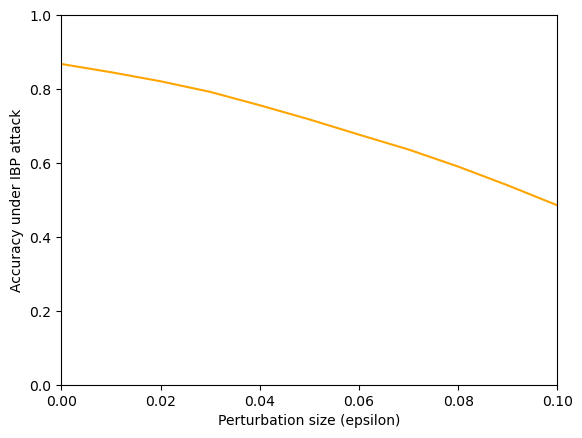

In [14]:
accs = np.array(accs)
plt.plot(epsilons, accs, color="orange")
plt.ylabel("Accuracy under IBP attack")
plt.xlabel("Perturbation size (epsilon)")
plt.xlim(0, 0.1)
plt.ylim(0, 1)

/tmp/ipykernel_6351/2050310183.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


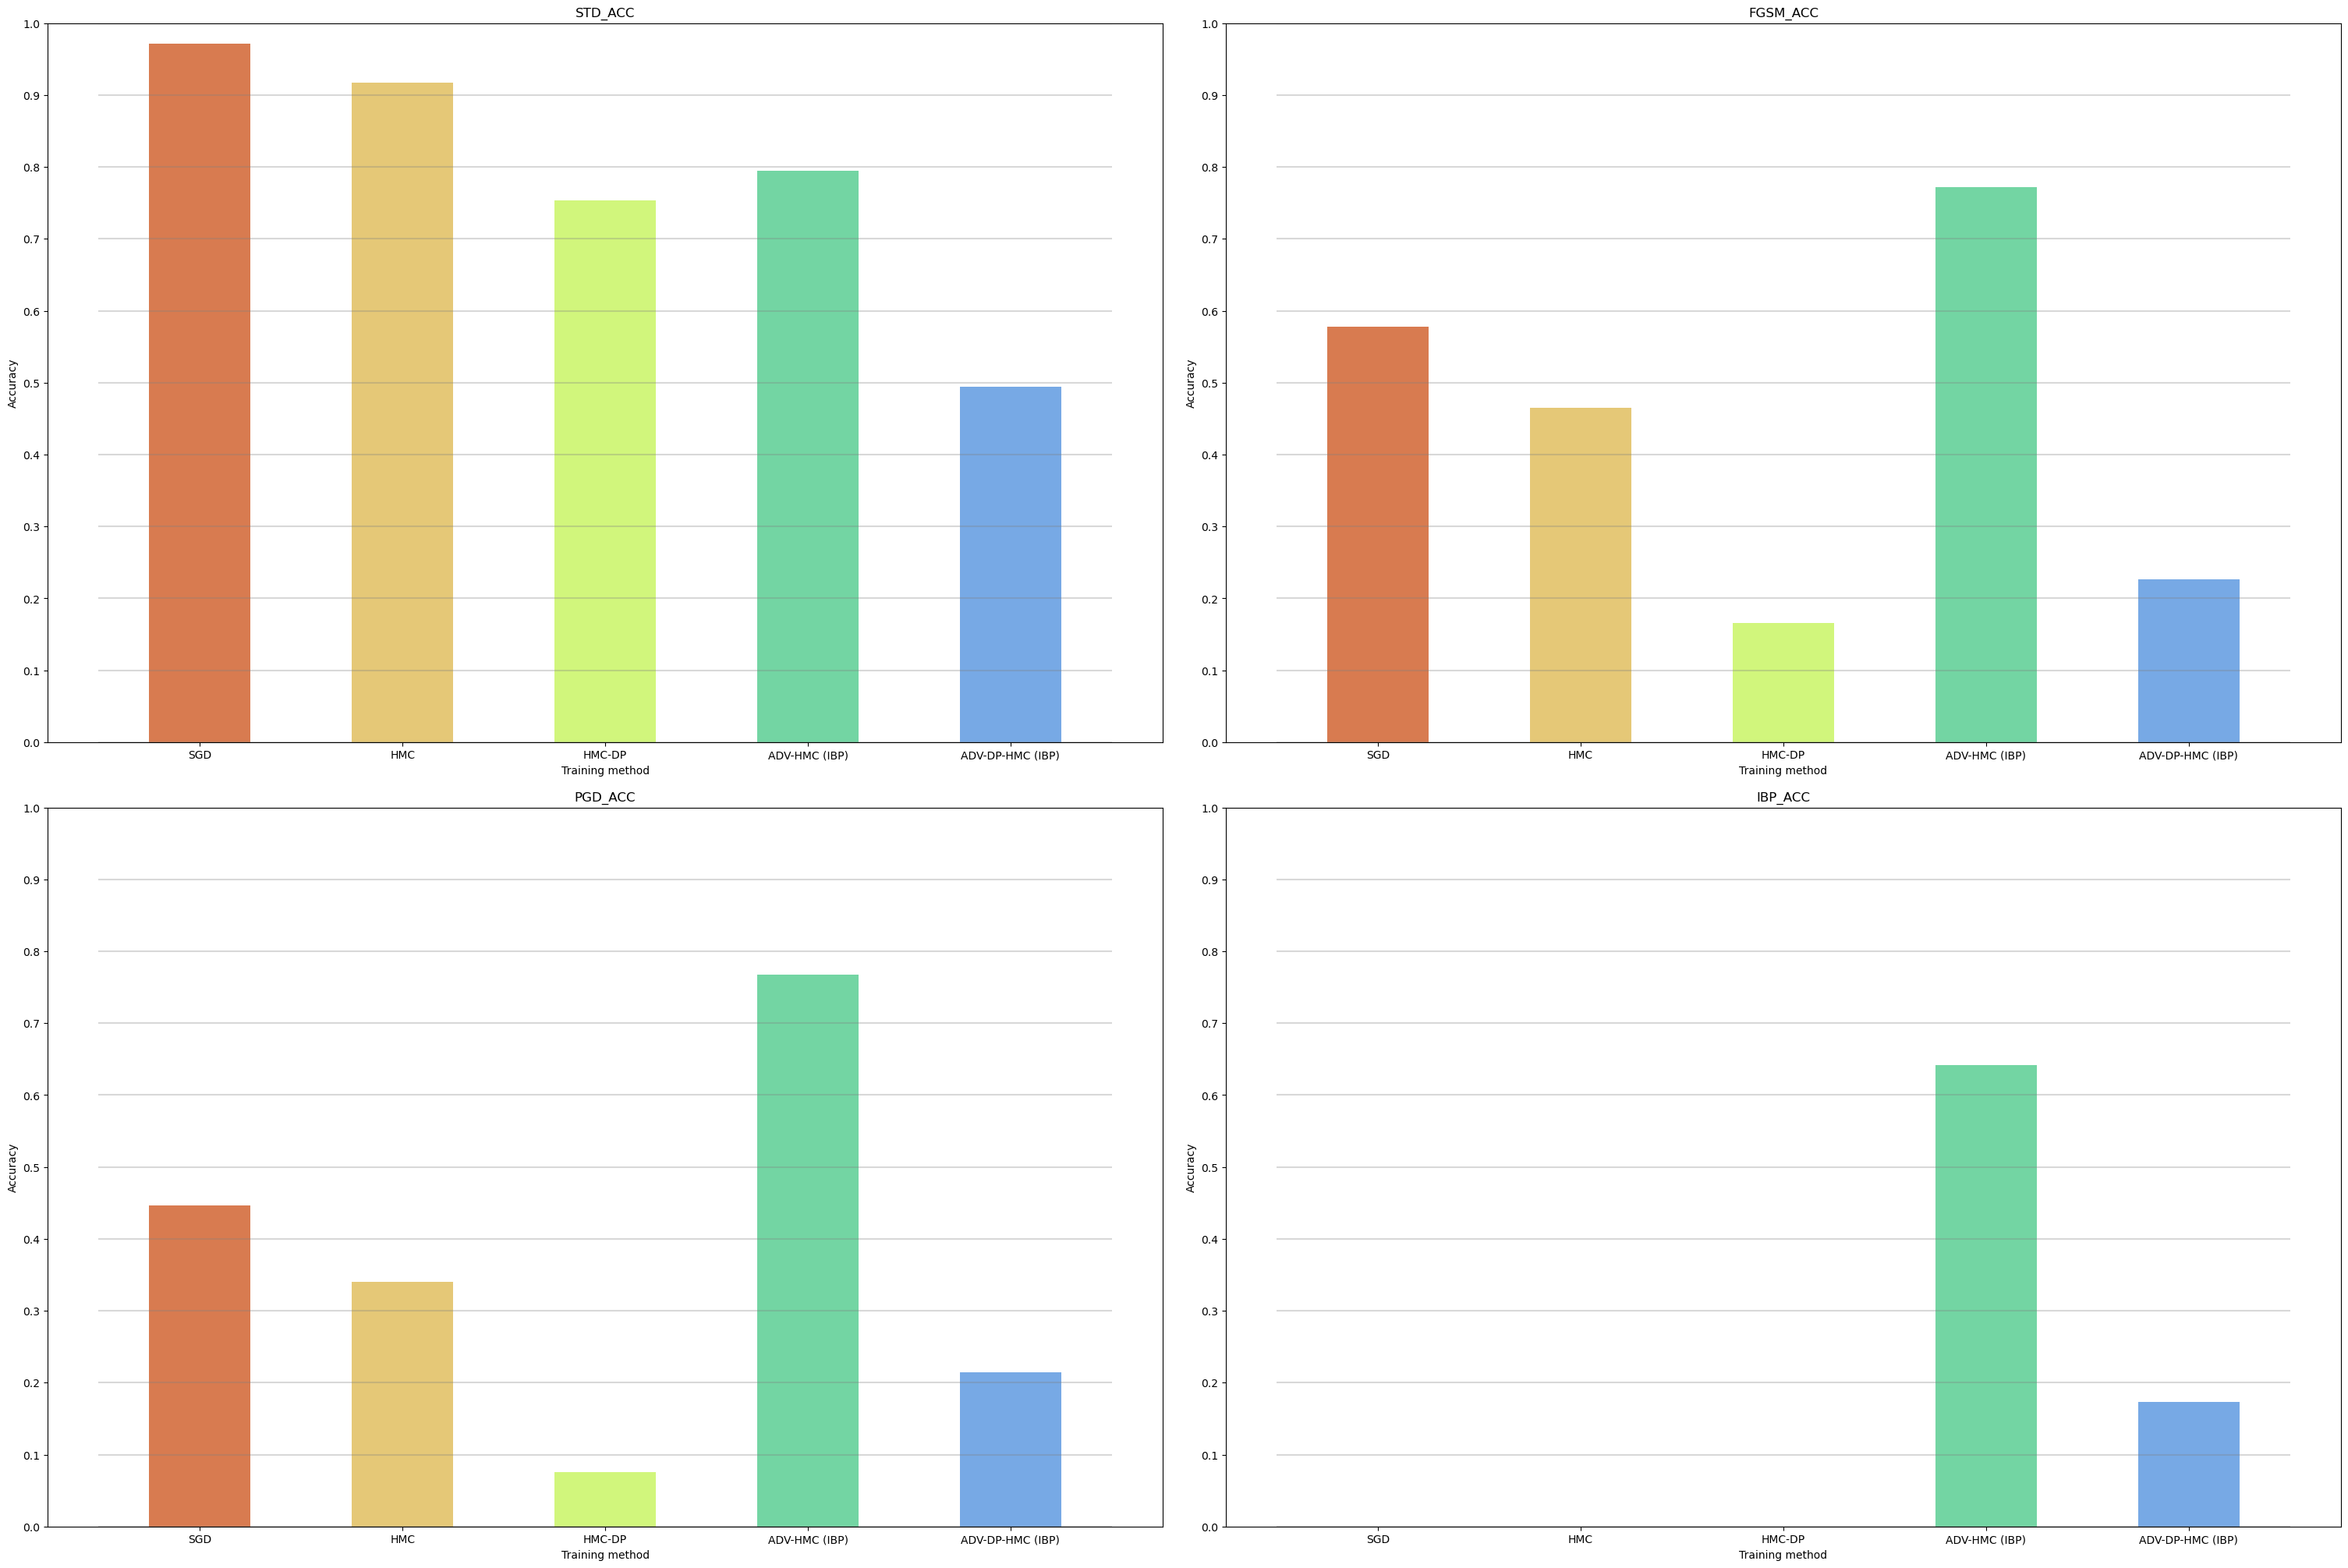

In [5]:
plot_metrics("MNIST", "accuracy", for_adv_comparison=False)

/tmp/ipykernel_6351/2050310183.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


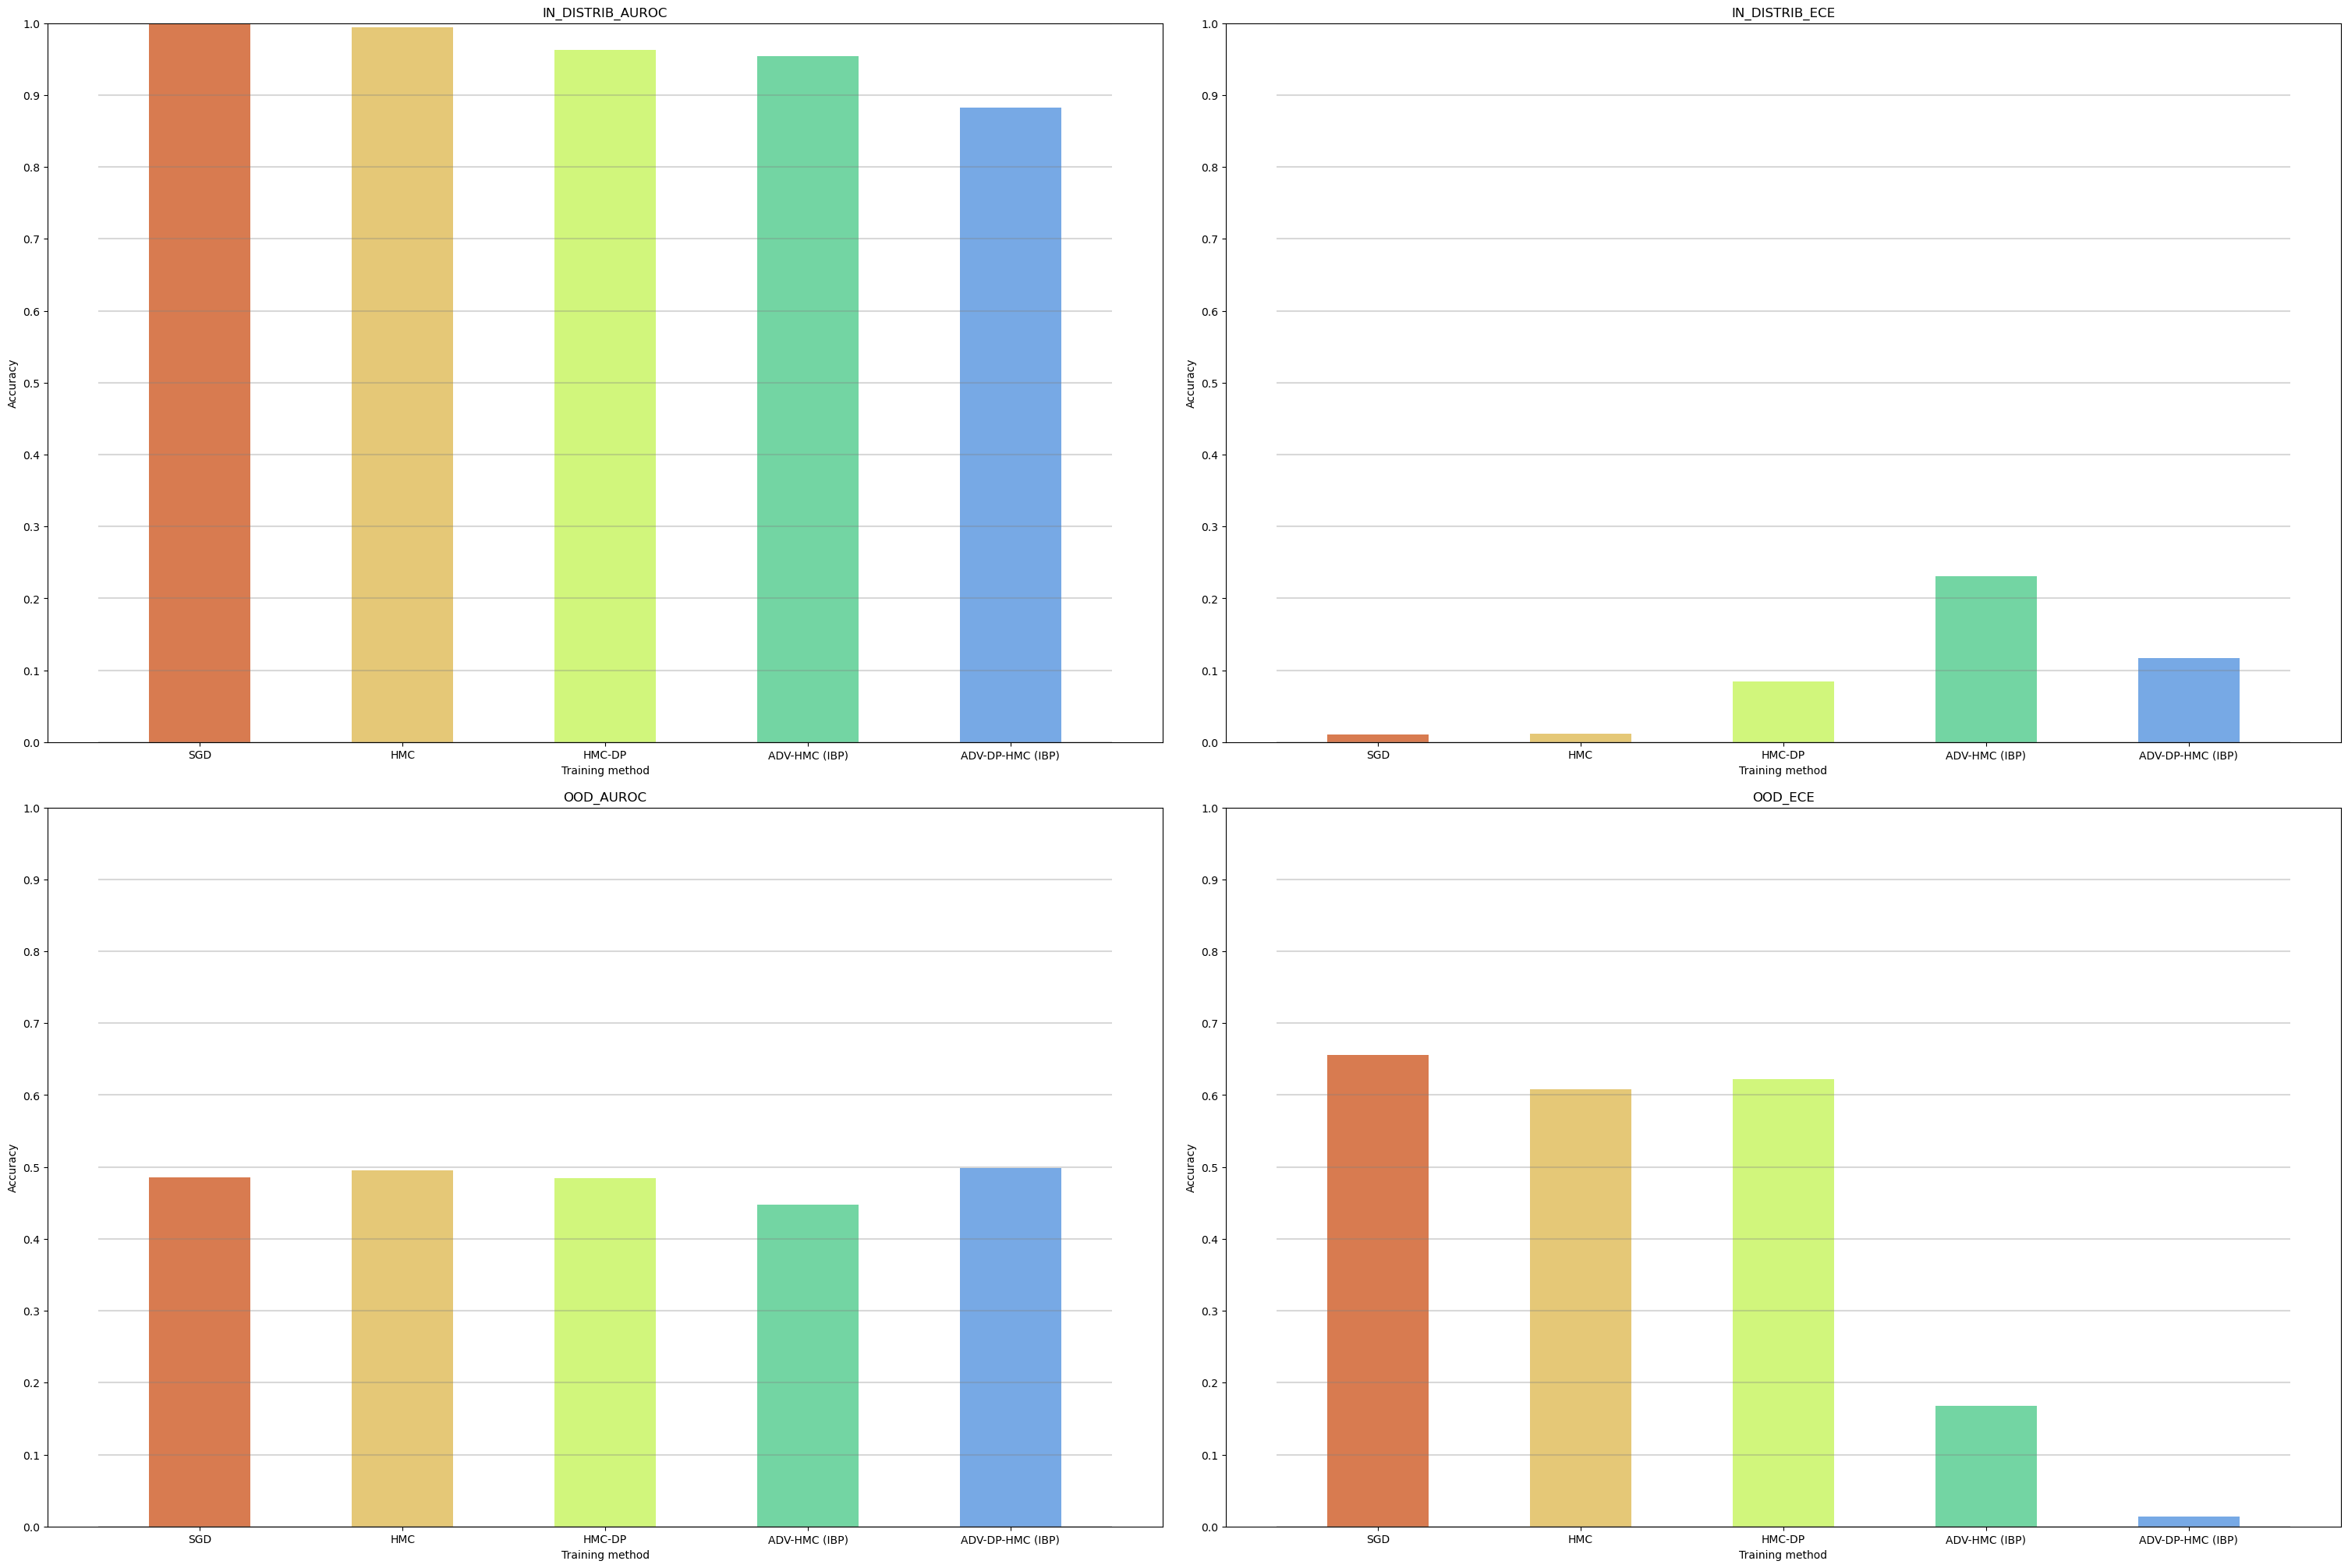

In [6]:
plot_metrics("MNIST", "uncertainty", for_adv_comparison=False)